In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Questions
What are the questions that I want to answer, given the data that I now have?
- How many jobs are remote?
- For jobs with pay range information, what is the average floor for each job category? Ceiling?
- Is there a tendency for a particular job to be remote more than another?
- What are the top 20 jobs that are being sought after?
- When you remove very old posts (30+ days) how much do these figures change?
    - what could be the reason for some of the older jobs hanging out on the job boards?
- What are the top 20 companies really pushing to hire?
- What are the top 20 locations that are hiring? Does it matter?

This could be structured in the typical "who, what, where, when"
- **Who** -> who are the companies that are recruiting the most?
- **What** -> what are the jobs that are most sought after
- **Where** -> what states are hiring the most people (with the understanding that a lot of work is remote, but this could change if restrictions begin to lift)
- **When** -> are there less newer jobs (7 days or newer). Does it matter?

### Extra 
- how many details are included in the job description snippet?
- can we use LDA to extract the most commonly desired topics?

In [2]:
jobs = pd.read_csv('indeed_jobs.csv', sep='|')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",NaN,0,"Our advanced web tools, client marketing progr...",30+ days ago,Marketing Technologist
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",NaN,0,Produces clear documentation for marketing pag...,30+ days ago,Marketing Technologist
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",NaN,0,Supports marketing related trade shows and ven...,7 days ago,Marketing Technologist
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",NaN,0,Work with hospital strategy department and mar...,13 days ago,Marketing Technologist
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",NaN,0,Related work experience can include process en...,30+ days ago,Marketing Technologist


In [3]:
jobs.shape

(248009, 8)

In [4]:
jobs.loc[(jobs['job_post_age'] == 'Just posted') |
         (jobs['job_post_age'] == 'Today')] = '0'
jobs['job_post_age'].value_counts()

30+ days ago    120746
0                11208
1 day ago        10348
5 days ago        8358
6 days ago        8175
7 days ago        7431
2 days ago        6931
8 days ago        6734
13 days ago       5377
12 days ago       5324
14 days ago       4949
9 days ago        4550
15 days ago       4525
20 days ago       3879
19 days ago       3871
21 days ago       3856
22 days ago       3591
28 days ago       3404
26 days ago       3229
16 days ago       3195
4 days ago        3090
27 days ago       3069
23 days ago       2996
29 days ago       2942
11 days ago       1797
18 days ago       1376
25 days ago       1126
3 days ago         768
10 days ago        493
17 days ago        371
24 days ago        300
Name: job_post_age, dtype: int64

In [5]:
jobs['job_post_age'] = jobs['job_post_age'].str.replace('[^0-9]', '')
jobs['job_post_age'] = jobs['job_post_age'].astype(int)
jobs.dtypes

role            object
company         object
location        object
pay             object
remote          object
details         object
job_post_age     int64
search_field    object
dtype: object

In [6]:
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",NaN,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",NaN,0,Produces clear documentation for marketing pag...,30,Marketing Technologist
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",NaN,0,Supports marketing related trade shows and ven...,7,Marketing Technologist
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",NaN,0,Work with hospital strategy department and mar...,13,Marketing Technologist
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",NaN,0,Related work experience can include process en...,30,Marketing Technologist


In [7]:
jobs['remote'] = jobs['remote'].astype(int)

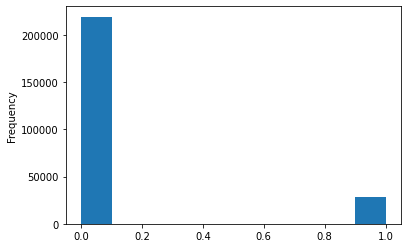

In [8]:
jobs['remote'].plot.hist();

### Pay Range Columns
It would be ideal to create pay range columns for the individual pay ranges ('an hour', 'a month', 'a year'. excluding the smallest groups) in order to create two standardized yearly pay columns like so:

|pay_floor|pay_ceiling|
|---------|-----------|
|50000    |90000      |
|75000    |125345     |

In [218]:
jobs['pay'] = jobs['pay'].fillna('N/A')
jobs.head()

,role,company,location,pay,remote,details,job_post_age,search_field
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",N/A,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",N/A,0,Produces clear documentation for marketing pag...,30,Marketing Technologist
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",N/A,0,Supports marketing related trade shows and ven...,7,Marketing Technologist
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",N/A,0,Work with hospital strategy department and mar...,13,Marketing Technologist
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist


In [ ]:
jobs['pay'] = jobs['pay'].str.replace('$', '')
jobs['pay'] = jobs['pay'].str.replace(',', '')

In [227]:
jobs['yearly'] = jobs['pay']

In [228]:
jobs.head(30)

,role,company,location,pay,remote,details,job_post_age,search_field,yearly
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",N/A,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist,N/A
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",N/A,0,Produces clear documentation for marketing pag...,30,Marketing Technologist,N/A
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",N/A,0,Supports marketing related trade shows and ven...,7,Marketing Technologist,N/A
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",N/A,0,Work with hospital strategy department and mar...,13,Marketing Technologist,N/A
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist,N/A
5,Sleep Lab Manager,"Pulmonary Institute of Arizona, PC","Tucson, AZ",N/A,0,Current state Respiratory Therapist and Board ...,26,Marketing Technologist,N/A
6,Snr Key Account Technology Engineer II - ALD,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist,N/A
7,Ambulatory Services Senior Director Neuro/Orth...,Banner Health,"Phoenix, AZ 85006 (Central City area)",N/A,0,Independently leads teams of peers and associa...,30,Marketing Technologist,N/A
8,Salesforce Developer - US Delivery Center,Deloitte,"Gilbert, AZ 85297",N/A,0,Build Salesforce solutions on Salesforce Cloud...,28,Marketing Technologist,N/A
9,Senior .Net Engineer,Digital Air Strike,"Scottsdale, AZ 85251 (South Scottsdale area)",N/A,0,Net Engineer. The ideal candidate should be a ...,8,Marketing Technologist,N/A


In [229]:
jobs.loc[~jobs['yearly'].str.contains('a year'), 'yearly'] = np.nan
jobs.head(30)

,role,company,location,pay,remote,details,job_post_age,search_field,yearly
0,Lead Software Engineer - eCommerce,COVETRUS INC,"Birmingham, AL 35203",N/A,0,"Our advanced web tools, client marketing progr...",30,Marketing Technologist,NaN
1,Associate Director of UAA Student Web Experience,University of Alaska,"Anchorage, AK 99508 (Rogers Park area)",N/A,0,Produces clear documentation for marketing pag...,30,Marketing Technologist,NaN
2,"Sales Support, Coronary Clinical Specialist - ...",Philips,"Tucson, AZ",N/A,0,Supports marketing related trade shows and ven...,7,Marketing Technologist,NaN
3,Laboratory Operations Manager,Lighthouse Lab Services,"Phoenix, AZ 85016 (Camelback East area)",N/A,0,Work with hospital strategy department and mar...,13,Marketing Technologist,NaN
4,Snr Key Account Technology Engineer I - EPI,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist,NaN
5,Sleep Lab Manager,"Pulmonary Institute of Arizona, PC","Tucson, AZ",N/A,0,Current state Respiratory Therapist and Board ...,26,Marketing Technologist,NaN
6,Snr Key Account Technology Engineer II - ALD,ASM,"Phoenix, AZ",N/A,0,Related work experience can include process en...,30,Marketing Technologist,NaN
7,Ambulatory Services Senior Director Neuro/Orth...,Banner Health,"Phoenix, AZ 85006 (Central City area)",N/A,0,Independently leads teams of peers and associa...,30,Marketing Technologist,NaN
8,Salesforce Developer - US Delivery Center,Deloitte,"Gilbert, AZ 85297",N/A,0,Build Salesforce solutions on Salesforce Cloud...,28,Marketing Technologist,NaN
9,Senior .Net Engineer,Digital Air Strike,"Scottsdale, AZ 85251 (South Scottsdale area)",N/A,0,Net Engineer. The ideal candidate should be a ...,8,Marketing Technologist,NaN


In [231]:
jobs.loc[134000:134030, ('pay', 'yearly')]

,pay,yearly
134000,0,NaN
134001,N/A,NaN
134002,60000 - 85000 a year,60000 - 85000 a year
134003,0,NaN
134004,0,NaN
134005,N/A,NaN
134006,N/A,NaN
134007,56459 - 75343 a year,56459 - 75343 a year
134008,N/A,NaN
134009,N/A,NaN


In [161]:
test.loc[(~test.str.contains('a year')) &
     (~test.str.contains('an hour')) &
    (~test.str.contains('a month'))] = np.nan